In [1]:
import bt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
data = bt.get('RSP,IWY,MOAT,PFF,VNQ', start='2019-01-01',end='2024-06-18')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Stat                 Bollinger_Strategy
-------------------  --------------------
Start                2012-04-24
End                  2024-06-20
Risk-free rate       0.00%

Total Return         372.95%
Daily Sharpe         0.68
Daily Sortino        1.16
CAGR                 13.64%
Max Drawdown         -50.92%
Calmar Ratio         0.27

MTD                  1.57%
3m                   0.82%
6m                   7.26%
YTD                  5.69%
1Y                   16.12%
3Y (ann.)            7.69%
5Y (ann.)            16.48%
10Y (ann.)           13.12%
Since Incep. (ann.)  13.64%

Daily Sharpe         0.68
Daily Sortino        1.16
Daily Mean (ann.)    15.25%
Daily Vol (ann.)     22.54%
Daily Skew           6.27
Daily Kurt           237.06
Best Day             38.90%
Worst Day            -21.75%

Monthly Sharpe       1.02
Monthly Sortino      2.09
Monthly Mean (ann.)  13.65%
Monthly Vol (ann.)   13.44%
Monthly Skew         0.67
Monthly Kurt         3.77
Best Month           19.98%
Worst

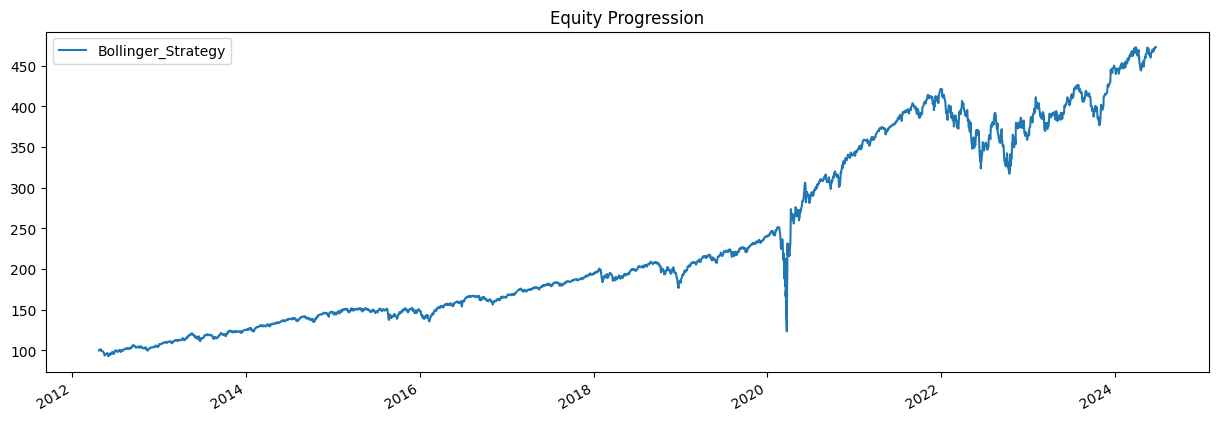

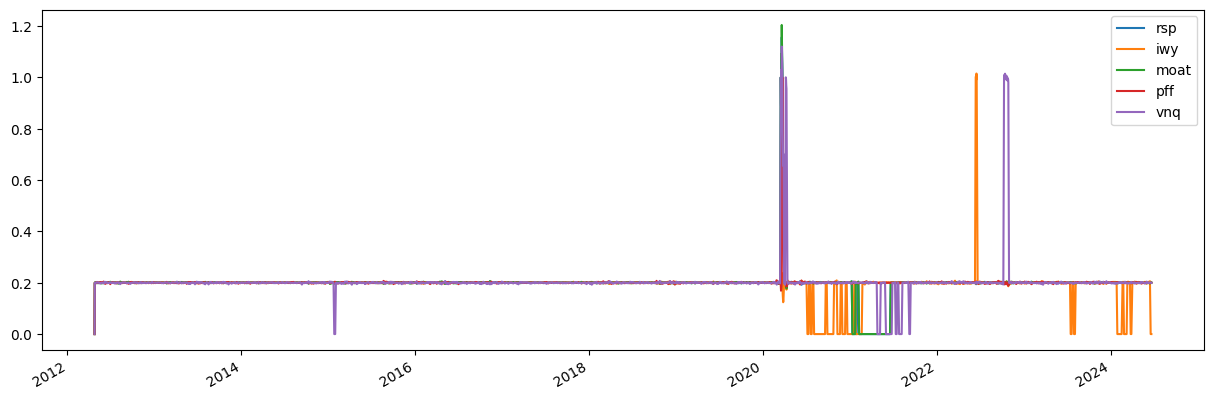

In [8]:
import bt
import pandas as pd

# 定义布林带逻辑的算法
class BollingerAlgo(bt.Algo):
    def __init__(self, lookback=252, std_dev=2):
        super(BollingerAlgo, self).__init__()
        self.lookback = lookback
        self.std_dev = std_dev

    def __call__(self, target):
        # 获取数据
        prices = target.universe.loc[:target.now, :]
        
        # 计算年线和布林带
        ma = prices.rolling(window=self.lookback).mean()
        std = prices.rolling(window=self.lookback).std()
        upper_band = ma + self.std_dev * std
        lower_band = ma - self.std_dev * std
        
        # 计算20%阈值
        upper_threshold = ma * 1.2
        lower_threshold = ma * 0.8
        
        # 初始化权重
        weights = pd.Series(0, index=prices.columns)
        
        # 获取当前价格
        current_prices = prices.iloc[-1]
        
        # 根据布林带逻辑设置权重
        for asset in prices.columns:
            if current_prices[asset] > upper_threshold[asset].iloc[-1]:
                weights[asset] = 0  # 卖出
            elif current_prices[asset] < lower_threshold[asset].iloc[-1]:
                weights[asset] = 1  # 买入
            else:
                weights[asset] = 1 / len(prices.columns)  # 等权分配
        
        # 设置权重
        target.temp['weights'] = weights
        return True

# 创建策略
strategy = bt.Strategy('Bollinger_Strategy', 
                       [bt.algos.RunWeekly(),
                        bt.algos.SelectAll(),
                        BollingerAlgo(),
                        bt.algos.Rebalance()])

# 获取数据
data = bt.get('RSP,IWY,MOAT,PFF,VNQ', start='2010-01-01')

# 创建回测
backtest = bt.Backtest(strategy, data)

# 运行回测
result = bt.run(backtest)

# 打印结果
result.display()

# 绘制权益曲线
result.plot()

# 绘制资产权重变化图
result.plot_security_weights()